In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.formula.api as smf

sns.set()

We begin by reading the data and summarizing the variables.

In [3]:
path = pathlib.Path.home() / 'data' / 'sleuth3' / 'case1001.csv'
df = pd.read_csv(path)
df.head()

,Distance,Height
0,253,100
1,337,200
2,395,300
3,451,450
4,495,600


In [4]:
summary = df.describe()
summary

,Distance,Height
count,7.000000,7.000000
mean,434.000000,492.857143
std,113.300485,327.144937
min,253.000000,100.000000
25%,366.000000,250.000000
50%,451.000000,450.000000
75%,514.500000,700.000000
max,573.000000,1000.000000


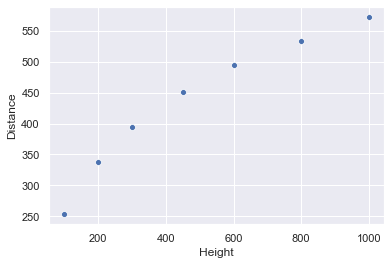

In [5]:
sns.scatterplot(x='Height', y='Distance', data=df)

Galileo's search for an experimental setting in which horizontal motion was not affected appreciably by friction (to study inertia) led him to construct an apparatus.  He placed a grooved, inclined plane on a table, released an ink-covered bronze ball in the groove at one of several heights above the table, and measured the horizontal distance between the table and the resulting ink spot on the floor.  The data are reported in units of _punti_ points.  One _punto_ is 169/180 millimeters.  (Data from S. Drake and J. MacLachlan, "Galileo's Discovery of the Parabolic Trajectory," _Scientific American_ 232 (1975): 102-10.)

In [6]:
model = smf.ols('Distance ~ Height + np.power(Height, 2) + np.power(Height, 3)', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1595.
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.66e-05
Time:                        19:18:49   Log-Likelihood:                -16.690
No. Observations:                   7   AIC:                             41.38
Df Residuals:                       3   BIC:                             41.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             155.7755    

/Users/jevans/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


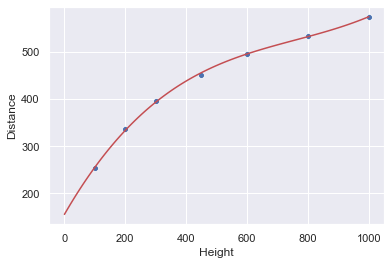

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x='Height', y='Distance', data=df, ax=ax)
df_exog = pd.DataFrame({'Height': np.linspace(0, 1000, 100)})
y = results.predict(exog=df_exog)
ax.plot(df_exog['Height'], y, color='r')

As shown above, a quadratic curve for the regression of horizontal distance on height fits well for initial heights less than 1,000 punti.  The data provides strong evidence that the coefficient of a cubic term differs from zero (two-sided $p$-value = 0.007).  Nonetheless, the quadratic model accounts for 99.03% of the variation in measured horizontal distance, and the cubic term explains only an additional 0.91% of the variation.  (_Note_: The significance of the cubic term can be explained by the effect of resistance.)

# Analysis of Variance
## Residual sum of squares from reduced model:  $Mean\{Distance\} = \beta_0$

In statsmodels, this is summarily reported as the F-statistic and p-value of the F-statistic.

In [13]:
print(f"F-statistic:  {results.fvalue:.4f}")
print(f"p-value:  {results.f_pvalue:.4f}")

F-statistic:  205.0267
p-value:  0.0001


This indicates overwhelming evidence that the coefficient of at least one of the explanatory variables $height$ and $height^2$ differs from zero.

The full ANOVA table can be constructed as follows.

In [24]:
pd.options.display.float_format = "{:.4f}".format
model = smf.ols('Distance ~ Height + np.power(Height, 2)', data=df)
results = model.fit()
ss_reduced = ((df.Distance - df.Distance.mean()) ** 2).sum()
index = pd.Index(['Regression', 'Residual', 'Total'], name='Source of Variation')
records = [
    (results.mse_model * results.df_model, results.df_model, results.mse_model, results.fvalue, results.f_pvalue),
    (results.mse_resid * results.df_resid, results.df_resid, results.mse_resid, np.NaN, np.NaN),    
    (ss_reduced, results.nobs - 1, np.NaN, np.NaN, np.NaN),
]
columns = ['Sums of Squares', 'd.f.', 'Mean Square', 'F-statistic', 'p-value']
dfss = pd.DataFrame.from_records(records, index=index, columns=columns)
dfss


,Sums of Squares,d.f.,Mean Square,F-statistic,p-value
Source of Variation,,,,,
Regression,76277.9219,2.0000,38138.9609,205.0267,0.0001
Residual,744.0781,4.0000,186.0195,nan,nan
Total,77022.0000,6.0000,nan,nan,nan


Note that the total sums of squares can be computed both as $(n-1)s_Y^2$ and as the regression sum of squares and the residual sum of squares.